## Aim of This Notebook
This notebook explores how fire impacts the composition of microbial communities in tropical peatlands, focusing on both Bacteria and Archaea at different soil depths. The analysis identifies the most abundant microbial classes, visualizes their distribution, and uses statistical modeling to detect which taxa respond to fire. The workflow demonstrates how to move from raw community data to interpretable results using both summary visualizations and differential abundance testing, with an emphasis on effect sizes and practical significance. This approach is directly relevant to data scientists interested in compositional data, robust group comparisons, and high-dimensional biological datasets.

### Load Required Packages
Load the necessary R packages for data wrangling, statistical modeling, and visualization. These packages provide specialized tools for handling microbiome data, including compositional analysis, effect size estimation, and publication-quality graphics. Loading them at the start ensures all downstream analyses are reproducible and robust.

In [1]:
## load packages
suppressPackageStartupMessages({
  library(DESeq2)
  library(Hmisc)
  library(janitor)
  library(patchwork)
  library(phyloseq)
  library(scales)
  library(tidyverse)
})

### Set Project Paths
Set up file paths for the project, data, and figure directories. Centralizing these paths makes the workflow portable and reproducible, ensuring that all data sources and outputs are organized and easy to locate.

In [2]:
## paths to directories
repo <- file.path("/Users/abandla/Desktop/2_research/1_manuscripts/2_2020_brunei_peat_fire/")
data <- file.path(repo, "1_data")
figures <- file.path(repo, "3_figures")

### Set Global Plotting Theme
Define a global plotting theme to standardize fonts, axis ticks, borders, and legends across all figures. Consistent visual style is important for clear communication, especially when comparing multiple panels or figures.

In [3]:
## set global theme options for plots
btp_theme <- theme(
  axis.text = element_text(size = 16, color = "black"),
  axis.text.y = element_text(margin = margin(0, 10, 0, 10)),
  axis.text.x = element_text(margin = margin(10, 0, 10, 0)),
  axis.title = element_text(size = 18),
  axis.ticks.length = unit(.25, "cm"),
  panel.border = element_rect(linewidth = 0.5, fill = NA),
  panel.background = element_rect(fill = NA),
  panel.grid = element_blank(),
  legend.text = element_text(size = 16),
  legend.title = element_text(size = 18),
  legend.key = element_rect(fill = NA),
  legend.background = element_rect(fill = NA)
)

### Load Microbiome Data
Load the phyloseq object, which combines the feature table (microbial counts), taxonomy (identities), and sample metadata (experimental conditions) into a single structure. This object-oriented approach streamlines downstream analysis, allowing for efficient filtering, aggregation, and visualization.

In [4]:
## import phyloseq object
btp_fire_ps <- readRDS(file.path(data, "3_phyloseq", "2020_btp_fire_ps.rds"))
btp_fire_ps

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3928 taxa and 24 samples ]
sample_data() Sample Data:       [ 24 samples by 6 sample variables ]
tax_table()   Taxonomy Table:    [ 3928 taxa by 7 taxonomic ranks ]

### Identify Top Microbial Classes
Calculate the top five most abundant classes for both Bacteria and Archaea in each sample, using a combination of relative abundance and prevalence. This step summarizes the dominant community members and sets the stage for visualizing how their composition changes with fire and depth.

In [5]:
## identify top five classes in 
## bacteria and archaea
top_five_microbial_classes <- btp_fire_ps %>%
  psmelt %>%
  group_by(Sample, Kingdom) %>%
  mutate(relative_abundance = (Abundance / sum(Abundance)) * 100) %>%
  group_by(Sample, Kingdom, Class, depth, psf_type) %>%
  reframe(class_relative_abundance = sum(relative_abundance)) %>%
  group_by(Class) %>% 
  mutate(
    mean_abundance = mean(class_relative_abundance),
    mean_prevalence = sum(class_relative_abundance > 0) / 24,
    F1 = 2 * ((mean_abundance * mean_prevalence) / (mean_abundance + mean_prevalence))
  ) %>%
  ungroup %>%
  group_by(Sample, Kingdom) %>%
  top_n(6, wt = F1) %>%
  ungroup

### Summarize Top Bacterial Classes
Aggregate and reshape the data to focus on the top five bacterial classes (plus an 'Others' category), grouped by peat status and depth. This prepares the data for clear, interpretable plotting of bacterial community structure.

In [6]:
## top five bacterial classes
top_five_bacterial_classes <- top_five_microbial_classes %>%
  filter(Kingdom == "Bacteria" & !is.na(Class)) %>%
  group_by(psf_type, depth, Class, Kingdom) %>%
  reframe(mean_abundance = mean(class_relative_abundance)) %>%
  pivot_wider(names_from = "Class", values_from = mean_abundance) %>%
  mutate(Others = 100 - rowSums(select_if(., is.numeric))) %>%
  pivot_longer(-c("psf_type", "depth", "Kingdom"), names_to = "Class", values_to = "Abundance") %>%
    mutate(Class = factor(
    Class,
    levels = c(
      "Acidobacteriae",
      "Actinobacteria",
      "Alphaproteobacteria",
      "Gammaproteobacteria",
      "Planctomycetes",
      "Others"
    )
  ))

### Summarize Top Archaeal Classes
Aggregate and reshape the data to focus on the top five archaeal classes (plus an 'Others' category), grouped by peat status and depth. This enables direct comparison of archaeal community structure across conditions.

In [7]:
## top five archaeal classes
top_five_archaeal_classes <- top_five_microbial_classes %>%
  filter(Kingdom != "Bacteria" & !is.na(Class)) %>%
  group_by(psf_type, depth, Class, Kingdom) %>%
  reframe(mean_abundance = mean(class_relative_abundance)) %>%
  pivot_wider(names_from = "Class", values_from = mean_abundance) %>%
  mutate(Others = 100 - rowSums(select_if(., is.numeric))) %>%
  pivot_longer(-c("psf_type", "depth", "Kingdom"), names_to = "Class", values_to = "Abundance") %>%
  mutate(Class = factor(
    Class,
    levels = c(
      "Bathyarchaeia",
      "Methanomicrobia",
      "Methanosarcinia",
      "Nitrososphaeria",
      "Thermoplasmata",
      "Others"
    )
  ))

### Plot Top Archaeal Classes
Visualize the relative abundance of the top five archaeal classes across depths and peat status using stacked bar plots. This figure makes it easy to see which archaeal groups dominate at each depth and how their composition shifts with fire.

In [8]:
## plot top five archaeal classes
top_five_archaeal_classes_figure <- top_five_archaeal_classes %>%
  ggplot(., aes(x = depth, y = Abundance, fill = Class)) +
  geom_bar(stat = "identity", color = "black", width = 1) +
  facet_wrap(~psf_type) +
  coord_cartesian(clip = "off") +
  btp_theme +
  theme(
    axis.text.y = element_text(margin = margin(0, 10, 0, 0)),
    axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5),
    panel.spacing.x = unit(0.8, "lines"),
    strip.background = element_rect(fill = NA),
    strip.text = element_text(size = 16),
    legend.key.size = unit(0.8, 'cm'),
    legend.spacing.y = unit(0.24, 'cm'),
    legend.spacing.x = unit(0.15, 'cm'),
    legend.margin = margin(0, 0, 0, 0)
  ) +
  scale_x_discrete(expand = c(0, 0), labels = c("Surface", "Mid", "Deep")) +
  scale_y_continuous(expand = c(0, 0)) +
   scale_fill_manual("Class",
    values = c(
      "Bathyarchaeia" = "#fb8072",
      "Methanomicrobia" = "#80b1d3",
      "Methanosarcinia" = "#b3de69",
      "Nitrososphaeria" = "#fccde5",
      "Thermoplasmata" = "#ccebc5",
      "Others" = "#d9d9d9"
    )
  ) +
guides(fill = guide_legend(byrow = TRUE)) +
ylab("Relative Abundance (%)") +
xlab("Depth")

### Plot Top Bacterial Classes
Visualize the relative abundance of the top five bacterial classes across depths and peat status using stacked bar plots. This complements the archaeal plot and highlights which bacterial groups are most affected by fire and depth.

In [9]:
## plot top five bacterial classes
top_five_bacterial_classes_figure <- top_five_bacterial_classes %>%
  ggplot(., aes(x = depth, y = Abundance, fill = Class)) +
  geom_bar(stat = "identity", color = "black", width = 1) +
  facet_wrap(~psf_type) +
  coord_cartesian(clip = "off") +
  btp_theme +
  theme(
    axis.text.y = element_text(margin = margin(0, 10, 0, 0)),
    axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5),
    panel.spacing.x = unit(0.8, "lines"),
    strip.background = element_rect(fill = NA),
    strip.text = element_text(size = 16),
    legend.key.size = unit(0.8, 'cm'),
    legend.spacing.y = unit(0.24, 'cm'),
    legend.spacing.x = unit(0.15, 'cm'),
    legend.margin = margin(0, 0, 0, 0)
  ) +
  scale_x_discrete(expand = c(0, 0), labels = c("Surface", "Mid", "Deep")) +
  scale_y_continuous(expand = c(0, 0)) +
   scale_fill_manual("Class",
    values = c(
      "Acidobacteriae" = "#8dd3c7",
      "Actinobacteria" = "#ffffb3",
      "Alphaproteobacteria" = "#bebada",
      "Gammaproteobacteria" = "#fdb462",
      "Planctomycetes" = "#bc80bd",
      "Others" = "#d9d9d9"
    )
  ) +
guides(fill = guide_legend(byrow = TRUE)) +
ylab("Relative Abundance (%)") +
xlab("Depth")

### View Combined Composition Plot
Display the combined figure showing both archaeal and bacterial class composition across depths and peat status. This side-by-side visualization provides an accessible summary of the main community shifts in response to fire.

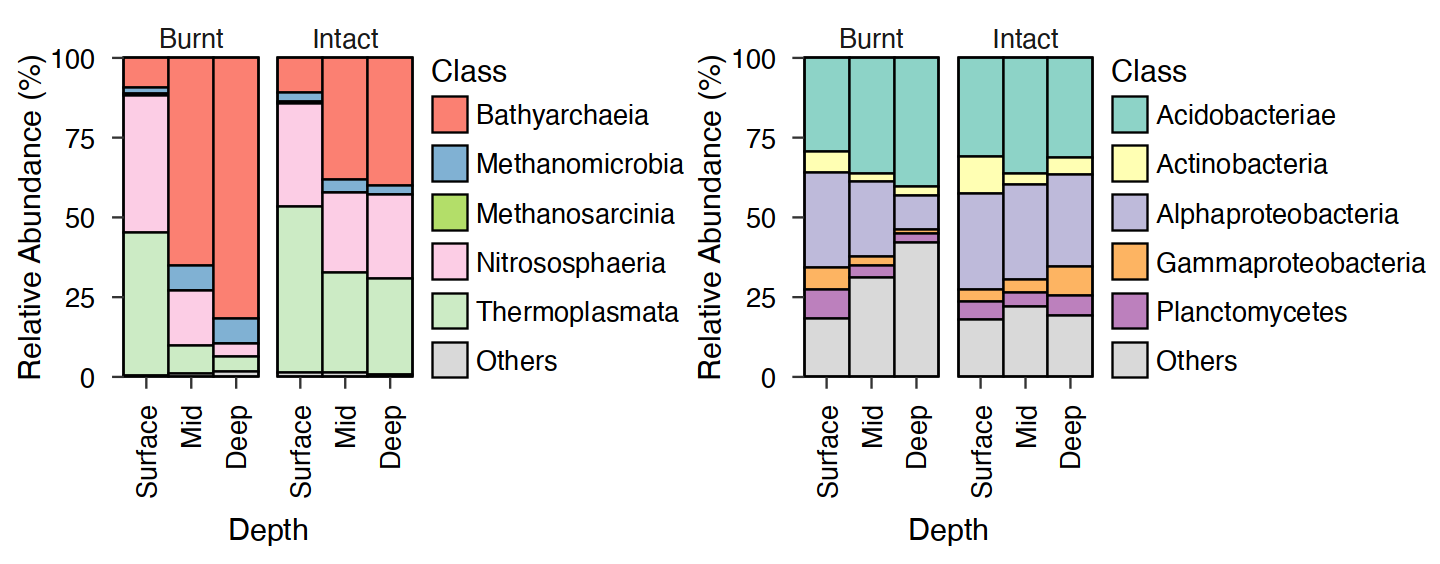

In [10]:
## view plot
options(repr.plot.width = 12, repr.plot.height = 4.7)
top_five_archaeal_classes_figure + top_five_bacterial_classes_figure

### Save Composition Plot
Export the combined composition figure as a PDF for use in reports or publications. Saving figures in a standardized format ensures results are easy to share and reproduce.

In [11]:
## save plot
pdf(file.path(figures, "1_main", "2_composition.pdf"), width = 12, height = 4.7)
top_five_archaeal_classes_figure + top_five_bacterial_classes_figure
dev.off()

pdf 
  2

### Differential Abundance: Class Level
Model differential abundance at the class level using DESeq2, accounting for peat status, depth, and their interaction. This step identifies which microbial classes are significantly more or less abundant in burnt versus intact peat at each depth, providing a statistical basis for interpreting fire responders.

In [ ]:
## fire responders at the
## class level
btp_fire_class_dds <- btp_fire_ps %>%
  tax_glom(., "Class") %>%
  phyloseq_to_deseq2(., ~psf_type + depth + psf_type:depth) %>%
  DESeq(., "Wald")

### Check Reference Levels for Class Model
Inspect the reference levels used in the DESeq2 model to ensure group comparisons are correctly specified. This is important for interpreting which group is considered the baseline in differential abundance testing.

In [ ]:
## check reference levels
## no differentials at depths 0-5 & 35-40
resultsNames(btp_fire_class_dds)

### Relevel and Refit Class Model
Change the reference depth to focus on a specific layer (e.g., 95-100 cm), then refit the model. This allows for targeted testing of fire effects at particular depths, which is crucial for understanding context-dependent responses.

In [ ]:
## relevel
btp_fire_class_dds$depth <- relevel(btp_fire_class_dds$depth, "95-100")
btp_fire_class_dds <- nbinomWaldTest(btp_fire_class_dds)
resultsNames(btp_fire_class_dds)

### Extract and Filter Significant Class Responders
Shrink effect sizes and filter for classes with statistically significant and biologically meaningful changes (adjusted p-value ≤ 0.05 and |log2 fold change| ≥ 1). This step highlights the most robust fire responders at the class level.

In [ ]:
## shrink effect sizes
btp_fire_class_depth_95_100 <- lfcShrink(
  dds = btp_fire_class_dds, 
  res = results(btp_fire_class_dds, contrast=c("psf_type","Intact","Burnt")),
  coef = "psf_type_Intact_vs_Burnt"
) %>%
  data.frame %>%
  filter(padj <= 0.05 & abs(log2FoldChange) >= 1) %>%
  rownames_to_column("ASV") %>%
  inner_join(
    tax_table(btp_fire_ps) %>%
    data.frame %>%
    rownames_to_column("ASV") %>%
    select(ASV, Kingdom, Phylum, Class)
  ) %>%
  arrange(-baseMean)

### Save Significant Class Responders
Export the list of significant class-level fire responders to a CSV file for further analysis or reporting. This ensures results are documented and easy to share.

In [ ]:
## save
write.csv(
  btp_fire_class_depth_95_100,
  file.path(data, "4_differentials", "2020_btp_fire_class_depth_95_100.csv"),
  row.names = FALSE,
  quote = FALSE
)

### Differential Abundance: ASV Level
Model differential abundance at the ASV (amplicon sequence variant) level using DESeq2, again accounting for peat status, depth, and their interaction. This high-resolution analysis pinpoints specific microbial lineages that respond to fire.

In [ ]:
## fire responders at the
## ASV level
btp_fire_asv_dds <- btp_fire_ps %>%
  phyloseq_to_deseq2(., ~psf_type + depth + psf_type:depth) %>%
  DESeq(., "Wald")

### Check Reference Levels for ASV Model
Inspect the reference levels in the ASV-level model to confirm the direction of group comparisons. This step ensures that the statistical contrasts are interpretable and aligned with the scientific question.

In [ ]:
## check reference levels
## no differentials at depth 35-40
## only one differential at depth 0-5
resultsNames(btp_fire_asv_dds)

### Relevel and Refit ASV Model
Change the reference depth and refit the ASV-level model to focus on specific layers. This enables depth-specific detection of fire-responsive ASVs.

In [ ]:
## relevel reference levels
btp_fire_asv_dds$depth <- relevel(btp_fire_asv_dds$depth, "95-100")
btp_fire_asv_dds <- nbinomWaldTest(btp_fire_asv_dds)
resultsNames(btp_fire_asv_dds)

### Extract and Filter Significant ASV Responders (Surface)
Shrink effect sizes and filter for ASVs with significant and substantial changes at the surface layer (e.g., 0-5 cm). This step identifies the most responsive microbial lineages near the peat surface.

In [ ]:
## shrink effect sizes
btp_fire_asv_depth_0_5 <- lfcShrink(
  dds = btp_fire_asv_dds, 
  res = results(btp_fire_asv_dds, contrast=c("psf_type","Intact","Burnt")),
  coef = "psf_type_Intact_vs_Burnt"
) %>%
  data.frame %>%
  filter(padj <= 0.05 & abs(log2FoldChange) >= 1) %>%
  rownames_to_column("ASV") %>%
  inner_join(
    tax_table(btp_fire_ps) %>%
    data.frame %>%
    rownames_to_column("ASV") %>%
    select(ASV, Kingdom, Phylum, Class, Order, Family, Genus)
  ) %>%
  arrange(-baseMean)

### Extract and Filter Significant ASV Responders (Deep)
Shrink effect sizes and filter for ASVs with significant and substantial changes at the deep layer (e.g., 95-100 cm). This highlights fire-responsive lineages in the deepest sampled peat.

In [ ]:
## shrink effect sizes
btp_fire_asv_depth_95_100 <- lfcShrink(
  dds = btp_fire_asv_dds, 
  res = results(btp_fire_asv_dds, contrast=c("psf_type","Intact","Burnt")),
  coef = "psf_type_Intact_vs_Burnt"
) %>%
  data.frame %>%
  filter(padj <= 0.05 & abs(log2FoldChange) >= 1) %>%
  rownames_to_column("ASV") %>%
  inner_join(
    tax_table(btp_fire_ps) %>%
    data.frame %>%
    rownames_to_column("ASV") %>%
    select(ASV, Kingdom, Phylum, Class, Order, Family, Genus)
  ) %>%
  arrange(-baseMean)

### Save Significant ASV Responders (Deep)
Export the list of significant ASV-level fire responders at the deep layer to a CSV file. This preserves high-resolution results for downstream analysis or publication.

In [ ]:
## save
write.csv(
  btp_fire_asv_depth_95_100,
  file.path(data, "4_differentials", "2020_btp_fire_asv_depth_95_100.csv"),
  row.names = FALSE,
  quote = FALSE
)